In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torchvision.utils import make_grid
from torch.utils.data import DataLoader
import torchvision.transforms as tt
from torchvision.datasets import ImageFolder

## Подготовка данных

In [2]:
# Looking into the directory
data_dir = './dataset'
print(os.listdir(data_dir))
classes_train = os.listdir(data_dir + "/train")
classes_valid = os.listdir(data_dir + "/test")
print(f'Train Classes - {classes_train}')
print(f'Validation Classes - {classes_valid}')

['test', 'test_ext', 'train', 'train_ext']
Train Classes - ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']
Validation Classes - ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']


In [3]:
# Data transforms (Gray Scaling & data augmentation)
train_tfms = tt.Compose([tt.Grayscale(num_output_channels=1),
                         tt.RandomHorizontalFlip(),
                         tt.ToTensor()])

valid_tfms = tt.Compose([tt.Grayscale(num_output_channels=1), tt.ToTensor()])

In [4]:
# Emotion Detection datasets
train_ds = ImageFolder(data_dir + '/train', train_tfms)
valid_ds = ImageFolder(data_dir + '/test', valid_tfms)

In [5]:
batch_size = 200

In [6]:
num_workers_trn = 0 #3
num_workers_val = 0 #3

In [7]:
# PyTorch data loaders
train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=num_workers_trn, pin_memory=True)
valid_dl = DataLoader(valid_ds, batch_size*2, num_workers=num_workers_val, pin_memory=True)

In [8]:
def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 12))
        ax.set_xticks([]); ax.set_yticks([])
        print(images[0].shape)
        ax.imshow(make_grid(images[:64], nrow=8).permute(1, 2, 0))
        break

torch.Size([1, 48, 48])


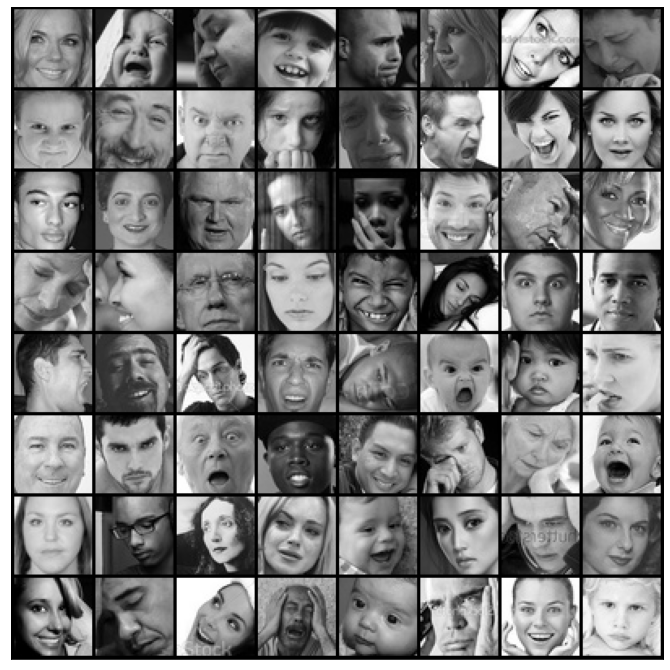

In [9]:
show_batch(train_dl)

## Использование GPU, если доступно

In [10]:
def get_default_device():
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        return len(self.dl)

In [11]:
device = get_default_device()
device

device(type='cpu')

In [12]:
train_dl = DeviceDataLoader(train_dl, device)
valid_dl = DeviceDataLoader(valid_dl, device)

## Создание шагов для обучения

In [13]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)
        loss = F.cross_entropy(out, labels)
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)
        loss = F.cross_entropy(out, labels)
        acc = accuracy(out, labels)
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], last_lr: {:.5f}, train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['lrs'][-1], result['train_loss'], result['val_loss'], result['val_acc']))

## Создание модели

In [14]:
def conv_block(in_channels, out_channels, pool=False):
    layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1), 
              nn.BatchNorm2d(out_channels), 
              nn.ReLU(inplace=True)]
    if pool: layers.append(nn.MaxPool2d(2))
    return nn.Sequential(*layers)

class ResNet(ImageClassificationBase):
    def __init__(self, in_channels, num_classes):
        super().__init__()
        
        self.input = conv_block(in_channels, 64)

        self.conv1 = conv_block(64, 64, pool=True)
        self.res1 = nn.Sequential(conv_block(64, 32), conv_block(32, 64))
        self.drop1 = nn.Dropout(0.5)
        
        self.conv2 = conv_block(64, 64, pool=True)
        self.res2 = nn.Sequential(conv_block(64, 32), conv_block(32, 64))
        self.drop2 = nn.Dropout(0.5)
        
        self.conv3 = conv_block(64, 64, pool=True)
        self.res3 = nn.Sequential(conv_block(64, 32), conv_block(32, 64))
        self.drop3 = nn.Dropout(0.5)
        
        self.classifier = nn.Sequential(nn.MaxPool2d(6), 
                                        nn.Flatten(),
                                        nn.Linear(64, num_classes))
        
    def forward(self, xb):
        out = self.input(xb)

        out = self.conv1(out)
        out = self.res1(out) + out
        out = self.drop1(out)
        
        out = self.conv2(out)
        out = self.res2(out) + out
        out = self.drop2(out)
        
        out = self.conv3(out)
        out = self.res3(out) + out
        out = self.drop3(out)
        
        return self.classifier(out)

In [15]:
model = to_device(ResNet(1, len(classes_train)), device)
model

ResNet(
  (input): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (conv1): Sequential(
    (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (res1): Sequential(
    (0): Sequential(
      (0): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )

## Обучение модели

In [16]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def fit_one_cycle(epochs, max_lr, model, train_loader, val_loader,
                  weight_decay=0, grad_clip=None, opt_func=torch.optim.SGD):
    torch.cuda.empty_cache()
    history = []
    
    # Set up custom optimizer with weight decay
    optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)
    # Set up one-cycle learning rate scheduler
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs, 
                                                steps_per_epoch=len(train_loader))
    
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        lrs = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            
            # Gradient clipping
            if grad_clip: 
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)
            
            optimizer.step()
            optimizer.zero_grad()
            
            # Record & update learning rate
            lrs.append(get_lr(optimizer))
            sched.step()
        
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['lrs'] = lrs
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [17]:
history = [evaluate(model, valid_dl)]
history

[{'val_loss': 1.9475563764572144, 'val_acc': 0.13305555284023285}]

In [18]:
epochs = 30
max_lr = 0.001
grad_clip = 0.2
weight_decay = 1e-4
opt_func = torch.optim.Adam

In [19]:
%%time
history += fit_one_cycle(epochs, max_lr, model, train_dl, valid_dl, 
                        grad_clip=grad_clip, weight_decay=weight_decay, opt_func=opt_func)

Epoch [0], last_lr: 0.00007, train_loss: 3.1483, val_loss: 1.9188, val_acc: 0.1761
Epoch [1], last_lr: 0.00015, train_loss: 1.9480, val_loss: 1.8444, val_acc: 0.1783
Epoch [2], last_lr: 0.00028, train_loss: 1.8579, val_loss: 1.8320, val_acc: 0.1878
Epoch [3], last_lr: 0.00044, train_loss: 1.7818, val_loss: 1.8079, val_acc: 0.2385
Epoch [4], last_lr: 0.00060, train_loss: 1.6425, val_loss: 1.7530, val_acc: 0.2771
Epoch [5], last_lr: 0.00076, train_loss: 1.5265, val_loss: 1.6674, val_acc: 0.3222
Epoch [6], last_lr: 0.00089, train_loss: 1.4627, val_loss: 1.7873, val_acc: 0.2506
Epoch [7], last_lr: 0.00097, train_loss: 1.4049, val_loss: 1.6085, val_acc: 0.3642
Epoch [8], last_lr: 0.00100, train_loss: 1.3582, val_loss: 1.4666, val_acc: 0.4562
Epoch [9], last_lr: 0.00099, train_loss: 1.3047, val_loss: 1.4216, val_acc: 0.4923
Epoch [10], last_lr: 0.00098, train_loss: 1.2584, val_loss: 1.3241, val_acc: 0.5262
Epoch [11], last_lr: 0.00095, train_loss: 1.2313, val_loss: 1.3185, val_acc: 0.5295
Ep

## Сохранение модели

In [20]:
model_path = './models/emotion_detection_model_state_' + str(len(classes_train)) + '.pth'
model_path

'./models/emotion_detection_model_state_7.pth'

In [21]:
# torch.save(model.state_dict(), model_path)

## Использование модели

In [22]:
net = to_device(ResNet(1, len(classes_train)), device)
net.load_state_dict(torch.load(model_path, map_location=device))
net.eval()

ResNet(
  (input): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (conv1): Sequential(
    (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (res1): Sequential(
    (0): Sequential(
      (0): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )

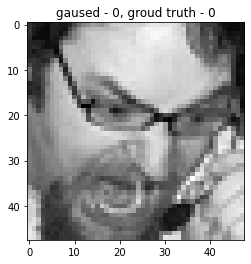

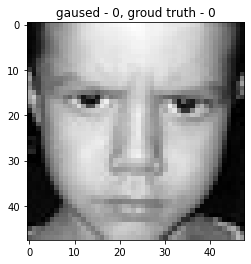

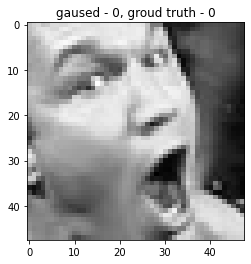

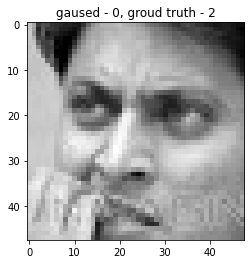

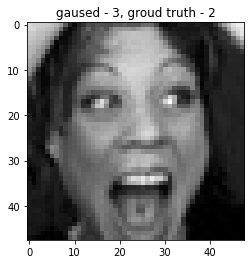

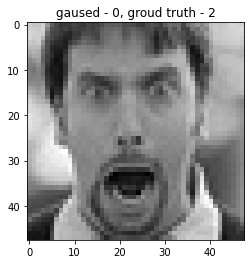

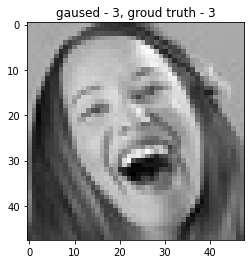

In [23]:
with torch.no_grad():
    for i, data in enumerate(valid_dl):
        images, labels = data
        #images, labels = Variable(images,volatile=True), Variable(labels,volatile=True)
        outputs = net(images)
        plt.title(f'gaused - {outputs[0].argmax()}, groud truth - {labels[0]}')
        plt.imshow(images[0].cpu().squeeze(), cmap='gray')
        plt.show()
        if i>5:
            break

## Анализ видеопотока

In [10]:
import os
import cv2
import torch
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as tt

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

face_classifier = cv2.CascadeClassifier("./models/haarcascade_frontalface_default.xml")

class_labels = ['сердитый', 'отвращение', 'страх', 'счастливый', 'нейтральный', 'грустный', 'удивление']
#class_labels = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']

model_path = './models/emotion_detection_model_state_' + str(len(class_labels)) + '.pth'
model_state = torch.load(model_path, map_location=device)

def conv_block(in_channels, out_channels, pool=False):
    layers = [
        nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
        nn.BatchNorm2d(out_channels),
        nn.ELU(inplace=True),
    ]
    if pool:
        layers.append(nn.MaxPool2d(2))
    return nn.Sequential(*layers)


def conv_block(in_channels, out_channels, pool=False):
    layers = [
        nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(inplace=True),
    ]
    if pool:
        layers.append(nn.MaxPool2d(2))
    return nn.Sequential(*layers)


class ResNet(nn.Module):
    def __init__(self, in_channels, num_classes):
        super().__init__()

        self.input = conv_block(in_channels, 64)

        self.conv1 = conv_block(64, 64, pool=True)
        self.res1 = nn.Sequential(conv_block(64, 32), conv_block(32, 64))
        self.drop1 = nn.Dropout(0.5)

        self.conv2 = conv_block(64, 64, pool=True)
        self.res2 = nn.Sequential(conv_block(64, 32), conv_block(32, 64))
        self.drop2 = nn.Dropout(0.5)

        self.conv3 = conv_block(64, 64, pool=True)
        self.res3 = nn.Sequential(conv_block(64, 32), conv_block(32, 64))
        self.drop3 = nn.Dropout(0.5)

        self.classifier = nn.Sequential(
            nn.MaxPool2d(6), nn.Flatten(), nn.Linear(64, num_classes)
        )

    def forward(self, xb):
        out = self.input(xb)

        out = self.conv1(out)
        out = self.res1(out) + out
        out = self.drop1(out)

        out = self.conv2(out)
        out = self.res2(out) + out
        out = self.drop2(out)

        out = self.conv3(out)
        out = self.res3(out) + out
        out = self.drop3(out)

        return self.classifier(out)


model = ResNet(1, len(class_labels))
model.load_state_dict(model_state)

#cap = cv2.VideoCapture(0)
cap = cv2.VideoCapture('./input.mp4')

while True:
    # Grab a single frame of video
    ret, frame = cap.read()
    if not ret:
        print("Can't receive frame (stream end?). Exiting ...")
        break
    frame = cv2.flip(frame, 1)
    labels = []
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    faces = face_classifier.detectMultiScale(gray, 1.3, 5)

    for (x, y, w, h) in faces:
        cv2.rectangle(frame, (x, y), (x + w, y + h), (255, 0, 0), 2)
        roi_gray = gray[y : y + h, x : x + w]
        roi_gray = cv2.resize(roi_gray, (48, 48), interpolation=cv2.INTER_AREA)

        if np.sum([roi_gray]) != 0:
            roi = tt.functional.to_pil_image(roi_gray)
            roi = tt.functional.to_grayscale(roi)
            roi = tt.ToTensor()(roi).unsqueeze(0)

            # make a prediction on the ROI
            tensor = model(roi)
            pred = torch.max(tensor, dim=1)[1].tolist()
            label = class_labels[pred[0]]

            label_position = (x, y)
            cv2.putText(
                frame,
                label,
                label_position,
                cv2.FONT_HERSHEY_COMPLEX,
                2,
                (0, 255, 0),
                3,
            )
        else:
            cv2.putText(
                frame,
                "No Face Found",
                (20, 60),
                cv2.FONT_HERSHEY_COMPLEX,
                2,
                (0, 255, 0),
                3,
            )

    cv2.imshow("Emotion Detector", frame)

    if cv2.waitKey(1) & 0xFF == ord("q"):
        break

cap.release()
cv2.destroyAllWindows()